# $b'B_o$ computation

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [2]:
from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

# cluster = LocalCluster(n_workers=61)
# client = Client(cluster)

# client

In [3]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [4]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:
dxx=0.5

In [6]:
chunks_new={'time_counter':10}

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal',chunks=chunks_new)

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal',chunks=chunks_new)

In [7]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'wrf_*.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[::2][-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'wrf_*.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[::2][-7:],chunks=chunks_new)

In [8]:

# path='/data/pacific/lrenault/SASI/FULL/WRF/'
# listmw2=glob(path+'wrf_*DAY*.nc');listmw2.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varfw2=xr.open_mfdataset(listmw2[-7:],chunks=chunks_new)

# Loading data

In [9]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

#### **Heat flux 'shflx' from ROMS is a computation of non-solar and solar heating components:**
#### **In this setting, cold (warm) SST triggers a heat flux into (out of) the ocean, with a positive value of 'shflx'.**
##### croco.shflx=  WRF.GSW- WRF.HFX - WRF.LH -(5.67e-8*(WRF.SST)**4)*emss -WRF.GLW)

In [10]:
%%time
chunks_new={'time_counter':10}

tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,100:-100,100:-200].compute();
tt=tt[:-1,1:-1,1:-1]

shf=varf.shflx#.groupby("time_counter.dayofyear").mean()
shf=shf.chunk(chunks=chunks_new);
shf=shf[:,100:-100,100:-200].compute();
shf=shf[:-1,1:-1,1:-1]

sht=vart.shflx#.groupby("time_counter.dayofyear").mean()
sht=sht.chunk(chunks=chunks_new);
sht=sht[:,100:-100,100:-200].compute();
sht=sht[:-1,1:-1,1:-1]


sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,100:-100,100:-200].compute();
sf=sf[:-1,1:-1,1:-1]

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,100:-100,100:-200].compute();
st=st[:-1,1:-1,1:-1]


CPU times: user 17.2 s, sys: 18.4 s, total: 35.5 s
Wall time: 4min 36s


In [11]:
# plt.figure()
# plt.plot(tf[1,500,:].nav_lat_rho,tf[1,500,:]-tf[1,:,:].mean())
# plt.figure()
# plt.plot(shf[1,500,:].nav_lat_rho,shf[1,500,:]-shf[1,:,:].mean())

# Computing $Bo_t$ and $b_T$

In [12]:
# N2r=(5.2*10**-3)**2
# N2r=(3.9e-3)**2
N2r=2.1757166666666666e-05 #caculated from FULL

In [13]:
cp=gsw.cp_t_exact(sf,tf,p=0).mean()
rho=1024
g=9.8

In [14]:
ct_f=gsw.CT_from_t(sf,tf,p=0)
alpha_f=gsw.alpha(sf,ct_f,p=0)
# lv_f=gsw.latentheat_evap_CT(sf,ct_f)


ct_t=gsw.CT_from_t(st,tt,p=0)
alpha_t=gsw.alpha(st,ct_t,p=0)
# lv_t=gsw.latentheat_evap_CT(st,ct_t)

In [15]:
# Bot_f=-(alpha_f*g*shf)/(rho*cp)
# Bot_t=-(alpha_t*g*sht)/(rho*cp)
Bot_f=(alpha_f*g*shf)/(rho*cp) #following Bishop 2020
Bot_t=(alpha_t*g*sht)/(rho*cp)




bt_f=alpha_f*g*(tf-tf.mean(axis=1).mean(axis=1))#spatial reference
bt_t=alpha_t*g*(tt-tt.mean(axis=1).mean(axis=1))#spatial reference

# bt_f=alpha_f.mean()*g*(tf-tf.mean())#time and spatial reference
# bt_t=alpha_t.mean()*g*(tt-tt.mean())#time and spatial reference


# Computing $Bo_s$ and $b_S$

##### Loading data from WRF

In [16]:
varfw.coords['2htime']=varfw.time_counter.dt.floor('2H')
vartw.coords['2htime']=vartw.time_counter.dt.floor('2H')

In [17]:
%%time
# chunks_new={'time_counter':40}
lhtf=regrid(varfw.LH.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
lhtt=regrid(vartw.LH.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
Pf=regrid(varfw.RAIN.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
Pt=regrid(vartw.RAIN.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 48s, sys: 2.56 s, total: 1min 50s
Wall time: 2min 13s


In [18]:
lhtf=lhtf[3:][::3]
lhtt=lhtt[3:][::3]

Pf=Pf[3:][::3]
Pt=Pt[3:][::3]

### Adjusting to same sampling frequency

In [19]:
# plt.figure(figsize=(10,8))
# plt.subplot(3,1,1)
# (varfw2.RAIN[100]/0.0393701).plot()
# plt.title('daily')
# plt.subplot(3,1,2)
# (varfw.RAIN[2400:2424].sum(axis=0)/24/0.0393701).plot()
# plt.title('hour?')
# plt.subplot(3,1,3)
# (varfw2.RAIN[100]-(varfw.RAIN[2400:2424].sum(axis=0)/24)).plot()
# plt.title('diff')




# # varfw.RAIN[0:24].mean(axis=0)
# plt.tight_layout()

In [20]:
# L=gsw.latentheat_evap_CT(sf,ct_f).mean().data #J   #/1000 #kJ
L=2257*1000 # J/Kg

In [21]:
Evap_f=lhtf.compute()/(L*rho)# m/s   #*86400
Evap_t=lhtt.compute()/(L*rho)# m/s   #*86400 #mm/day

beta_f=gsw.beta(sf,ct_f,p=0)
beta_t=gsw.beta(st,ct_t,p=0)

In [22]:
# EP_f=Evap_f.mean(axis=1).mean(axis=1)-(Pf.mean(axis=1).mean(axis=1)/(86400*1000));
# EP_f=Evap_f-(Pf.data/(86400*1000));
# EP_f=Evap_f-(Pf.compute()/(3600*1000));
EP_f=Evap_f-(Pf.compute()/(12*1000));




# EP_f=EP_f.assign_coords(DOY=('time_counter',sf.dayofyear.data))
# EP_f=EP_f.drop(['time_counter','time_centered'])
# EP_f=EP_f.rename({'time_counter':'dayofyear'})



# EP_t=Evap_t.mean(axis=1).mean(axis=1)-(Pt.mean(axis=1).mean(axis=1)/(86400*1000));
# EP_t=Evap_t-(Pt.data/(86400*1000));
# EP_t=Evap_t-(Pt.compute()/(3600*1000));
EP_t=Evap_t-(Pt.compute()/(12*1000));



# EP_t=EP_t.assign_coords(DOY=('time_counter',st.dayofyear.data))
# EP_t=EP_t.drop(['time_counter','time_centered'])
# EP_t=EP_t.rename({'time_counter':'dayofyear'})

In [23]:
Bos_f=-(g*beta_f)*(sf)*(EP_f.data) # Following Bishop et al (2020)
Bos_t=-(g*beta_t)*(st)*(EP_t.data)

# Bos_f=-(g*beta_f)*(sf)*(EP_f) 
# Bos_t=-(g*beta_t)*(st)*(EP_t)

bs_f=-g*beta_f*(sf-sf.mean(axis=1).mean(axis=1))
bs_t=-g*beta_t*(st-st.mean(axis=1).mean(axis=1))

# bs_f=-g*beta_f*(sf[:-1,:,:]-sf.mean())
# bs_t=-g*beta_t*(st[:-1,:,:]-st.mean())

In [24]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [25]:
%%time
with ProgressBar():
    btBt_f=xrft.isotropic_cross_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    btBt_t=xrft.isotropic_cross_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 52min 43s, sys: 2h 30min 45s, total: 3h 23min 29s
Wall time: 6min 5s


In [26]:
%%time
with ProgressBar():
    bsBs_f=xrft.isotropic_cross_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    bsBs_t=xrft.isotropic_cross_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 53min 8s, sys: 2h 33min 17s, total: 3h 26min 26s
Wall time: 6min 6s


In [27]:
%%time
with ProgressBar():
    btBs_f=xrft.isotropic_cross_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    btBs_t=xrft.isotropic_cross_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 53min 20s, sys: 2h 32min 37s, total: 3h 25min 57s
Wall time: 6min 5s


In [28]:
%%time
with ProgressBar():
    bsBt_f=xrft.isotropic_cross_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    bsBt_t=xrft.isotropic_cross_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 53min 41s, sys: 2h 33min 17s, total: 3h 26min 59s
Wall time: 6min 7s


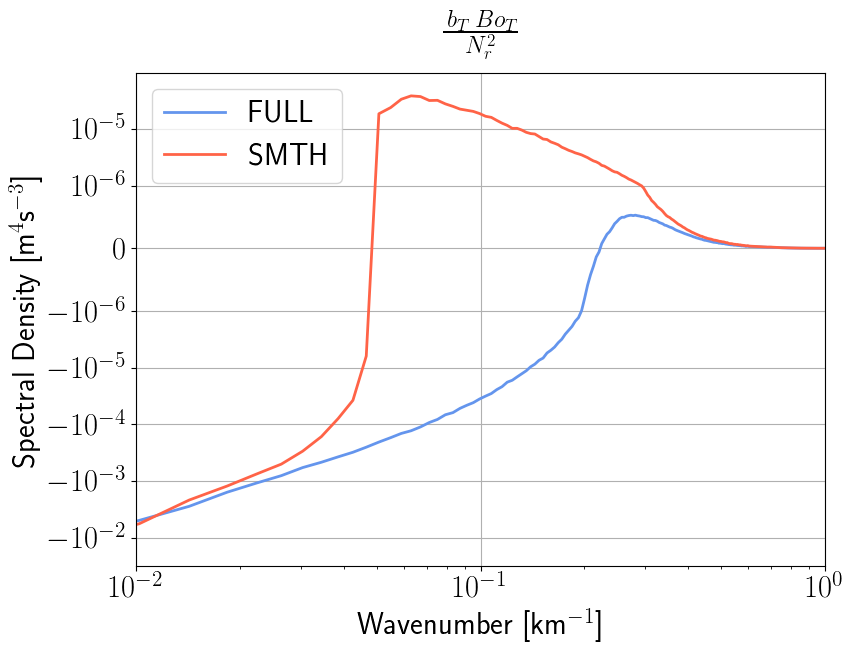

In [29]:
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,((1/N2r)*btBt_f.mean(axis=0))/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(btBt_t.freq_r/dxx,((1/N2r)*btBt_t.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()
plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{\,b_T \,Bo_T}{N^2_r}$',fontsize=25,y=1.05)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')

plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bTBoT_spectral.png')



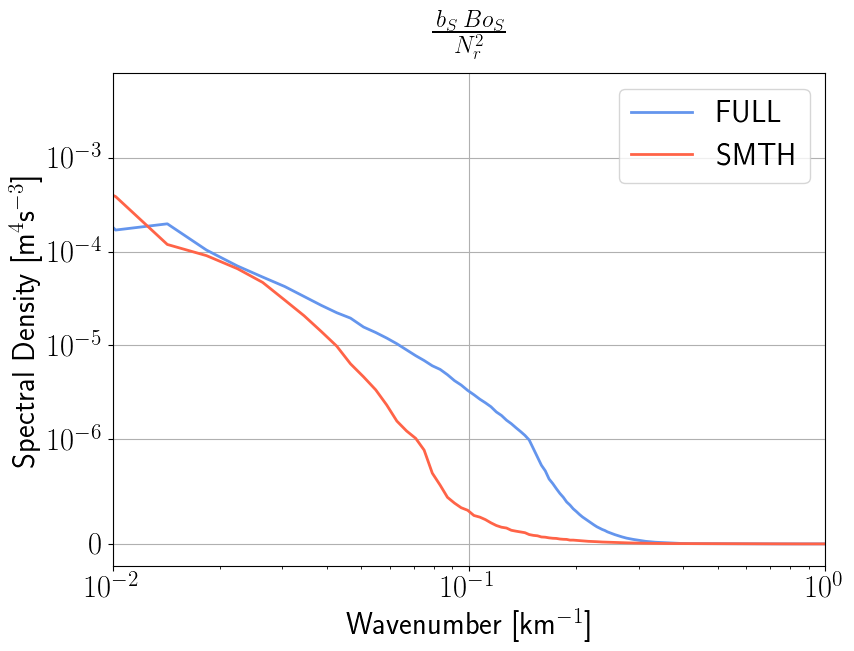

In [33]:
plt.figure(figsize=(9,7))


plt.plot(bsBs_f.freq_r/dxx,((1/N2r)*bsBs_f.mean(axis=0))/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(bsBs_t.freq_r/dxx,((1/N2r)*bsBs_t.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{ \,b_S \,Bo_S}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')

plt.xlim(1/100,1)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bSBoS_spectral.png')



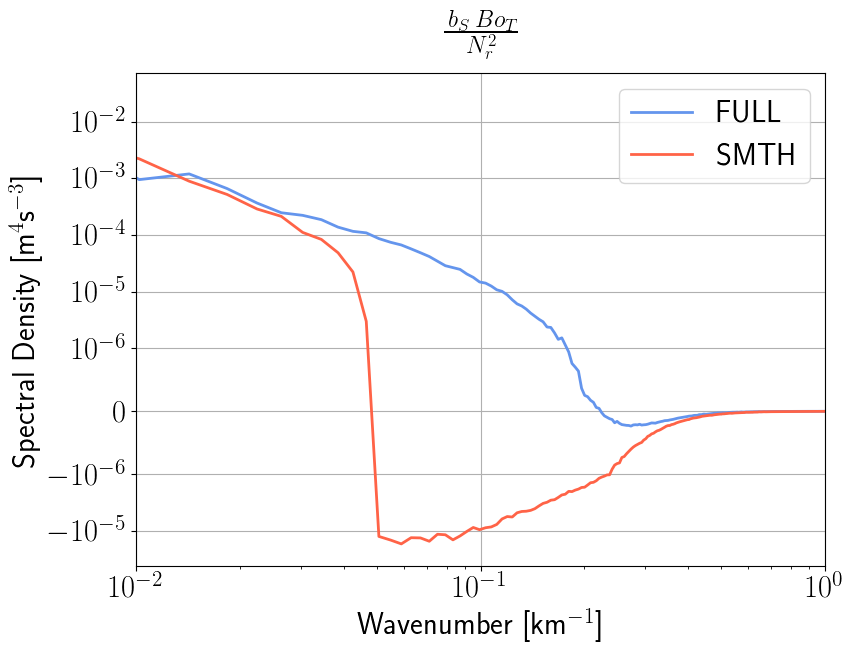

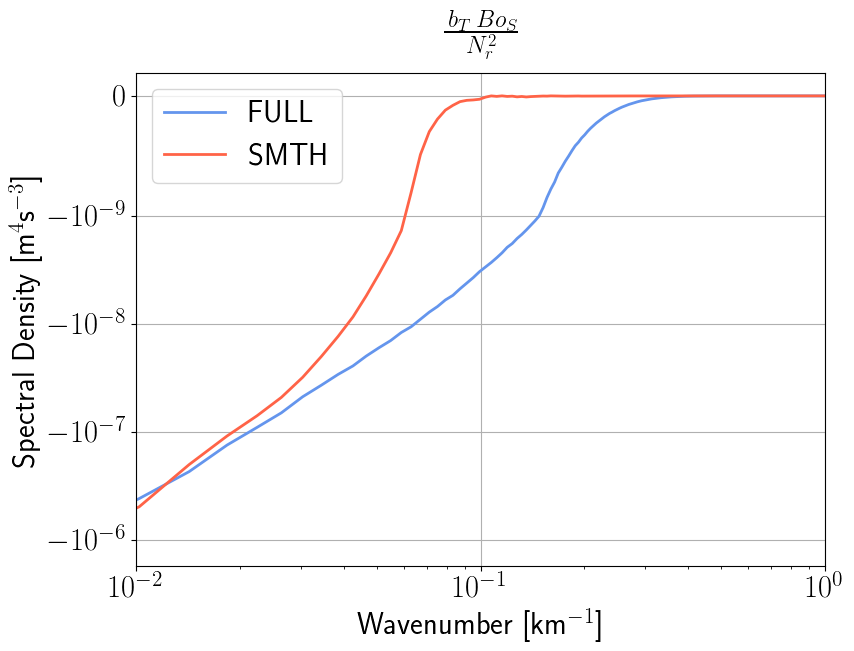

In [34]:
plt.figure(figsize=(9,7))
# 

plt.plot(bsBt_f.freq_r/dxx,((1/N2r)*bsBt_f.mean(axis=0))/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(bsBt_t.freq_r/dxx,((1/N2r)*bsBt_t.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{ \,b_S \,Bo_T}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bSBoT_spectral.png')





plt.figure(figsize=(9,7))


plt.plot(btBs_f.freq_r/dxx,(1/N2r)*btBs_f.mean(axis=0),label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(btBs_t.freq_r/dxx,(1/N2r)*btBs_t.mean(axis=0),label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-9)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{ \,b_T \,Bo_S}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bTBoS_spectral.png')




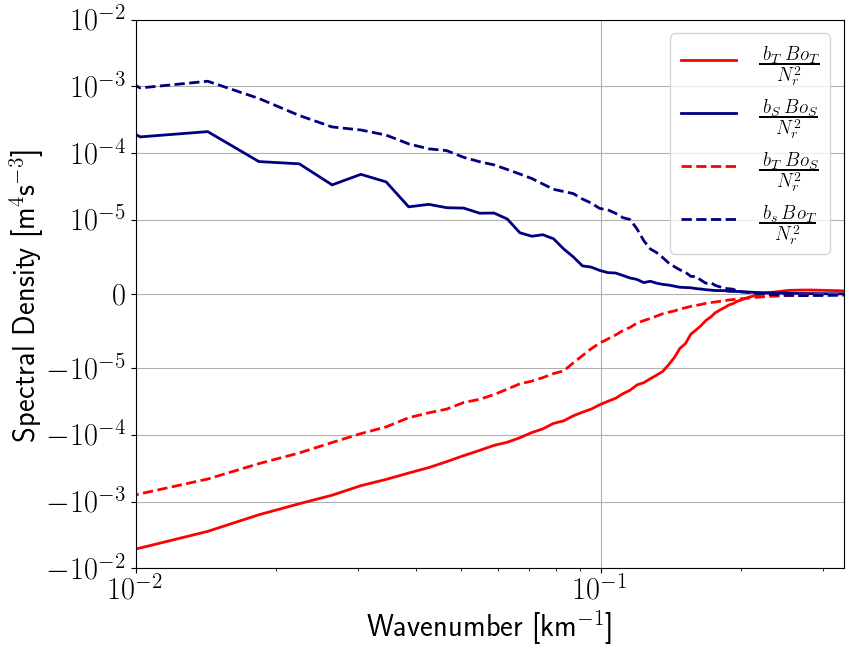

In [32]:
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,((1/N2r)*btBt_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_T \,Bo_T}{N^2_r}$',linewidth=2,color='red')
# plt.plot(btBt_t.freq_r/dxx,((1/N2r)*btBt_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='red')


plt.plot(bsBs_f.freq_r/dxx,((1/N2r)*bsBs_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_S \,Bo_S}{N^2_r}$',linewidth=2,color='navy')
# plt.plot(bsBs_t.freq_r/dxx,((1/N2r)*bsBs_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='navy')

plt.plot(btBs_f.freq_r/dxx,((1/N2r)*btBs_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_T \,Bo_S}{N^2_r}$',linestyle='--',linewidth=2,color='red')
# plt.plot(btBs_t.freq_r/dxx,((1/N2r)*btBs_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='tomato')



plt.plot(bsBt_f.freq_r/dxx,((1/N2r)*bsBt_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_s \,Bo_T}{N^2_r}$',linestyle='--',linewidth=2,color='navy')
# plt.plot(bsBt_t.freq_r/dxx,((1/N2r)*bsBt_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='turquoise')



# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 20})

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')



# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1/3)
plt.ylim(-1e-2,1e-2)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_all_spectral_v_allwavenumbers.png')
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_all_spectral_v_all_step_4.png')






## Sum of all components

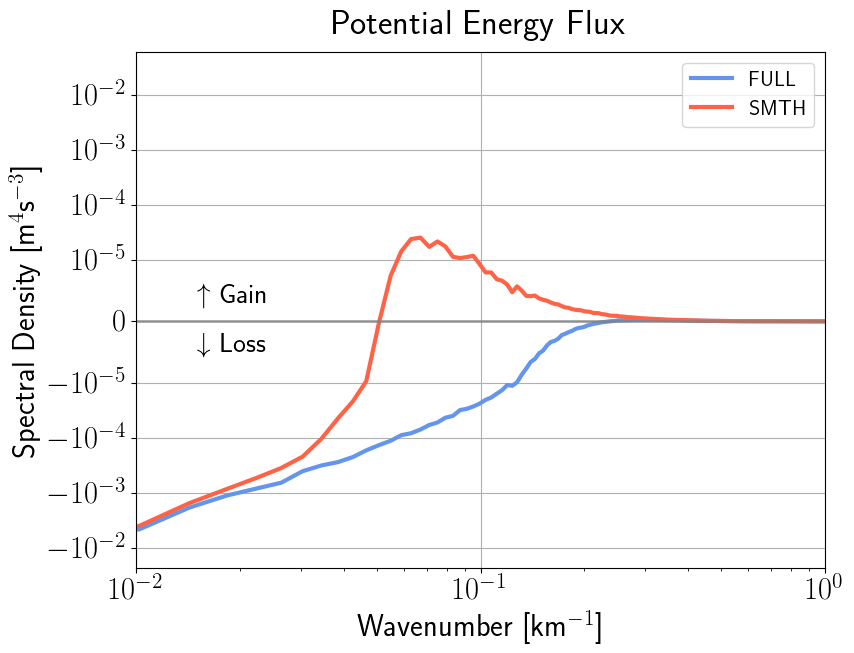

In [121]:
# plt.figure(figsize=(9,4))
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,
         ((1/N2r)*(btBt_f.mean(axis=0)+bsBs_f.mean(axis=0)+bsBt_f.mean(axis=0)+btBs_f.mean(axis=0)))/dxx*1e3,
                                      label='FULL',linewidth=3,color='cornflowerblue')
plt.plot(btBt_t.freq_r/dxx,
         ((1/N2r)*(btBt_t.mean(axis=0)+bsBs_t.mean(axis=0)+bsBt_t.mean(axis=0)+btBs_t.mean(axis=0)))/dxx*1e3,
                                     label='SMTH',linewidth=3,color='tomato')

plt.plot(btBt_t.freq_r/dxx,np.zeros(btBt_t[0].shape),linewidth=2,color='grey',alpha=0.7)





# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'Potential Energy Flux',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)




# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(-1e-4,1e-2)
plt.grid()

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_sum_spectral_v2poster_test2.png')

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_sum_spectral.png')

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_sum_spectral_allwavenumbers.png')






# Alternative Computation

In [27]:
%%time
with ProgressBar():
    bBo_full=xrft.isotropic_cross_spectrum((bs_f+bt_f).drop(['nav_lat_rho','nav_lon_rho']),
                                         (Bot_f+Bos_f).drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    bBo_smth=xrft.isotropic_cross_spectrum((bs_t+bt_t).drop(['nav_lat_rho','nav_lon_rho']),
                                         (Bot_t + Bos_t).drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 48min 41s, sys: 2h 26min 45s, total: 3h 15min 27s
Wall time: 5min 48s


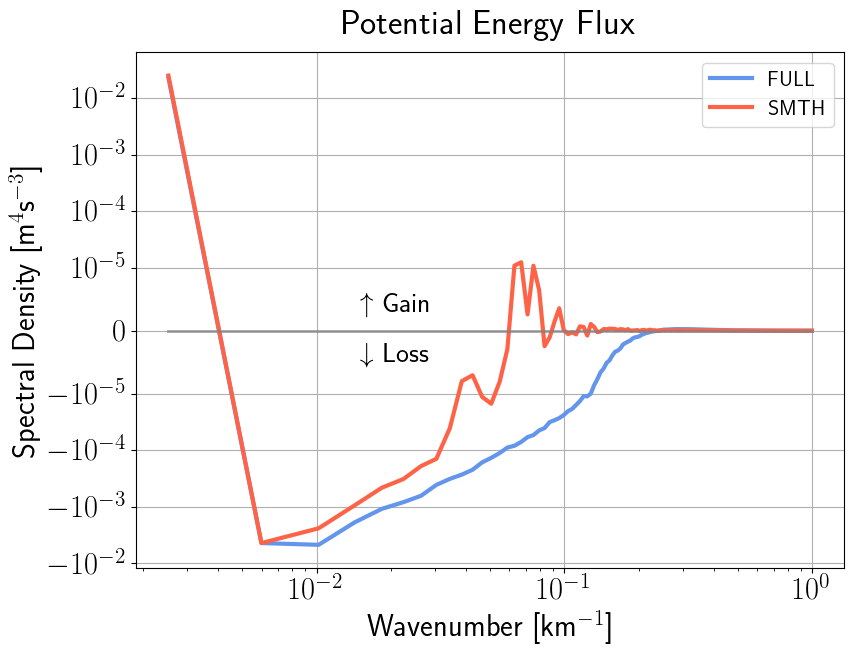

In [122]:
plt.figure(figsize=(9,7))


plt.plot(bBo_full.freq_r/dxx,
         ((1/N2r)*(bBo_full.mean(axis=0)))/dxx*1e3,
                                      label='FULL',linewidth=3,color='cornflowerblue')
plt.plot(bBo_smth.freq_r/dxx,
         ((1/N2r)*(bBo_smth.mean(axis=0)+bsBs_t.mean(axis=0)+bsBt_t.mean(axis=0)+btBs_t.mean(axis=0)))/dxx*1e3,
                                     label='SMTH',linewidth=3,color='tomato')

plt.plot(bBo_full.freq_r/dxx,np.zeros(bBo_full[0].shape),linewidth=2,color='grey',alpha=0.7)


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'Potential Energy Flux',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)




# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


# plt.xlim(1/100,1)
# plt.ylim(-1e-4,1e-2)
plt.grid()

plt.tight_layout()

# Estimate of the time scale $\Delta(EPE_{flux})$

In [60]:
bBo_FULL=((1/N2r)*(btBt_f+bsBs_f+bsBt_f+btBs_f))
bBo_SMTH=((1/N2r)*(btBt_t+bsBs_t+bsBt_t+btBs_t))


### Absolute

In [61]:
EPEflux_FULL_sum=(bBo_FULL[:,bBo_FULL.freq_r>1e-2]).sum()/dxx*1e3
EPEflux_SMTH_sum=(bBo_SMTH[:,bBo_SMTH.freq_r>1e-2]).sum()/dxx*1e3

print('DELTA PE_flux = {0} m3/s3'.format((EPEflux_SMTH_sum-EPEflux_FULL_sum).data))

DELTA PE_flux = 2.4386104862607927 m3/s3


### Time average

In [62]:

EPEflux_FULL_sum_t=(bBo_FULL[:,bBo_FULL.freq_r>1e-2]).mean('time_counter').sum()/dxx*1e3
EPEflux_SMTH_sum_t=(bBo_SMTH[:,bBo_SMTH.freq_r>1e-2]).mean('time_counter').sum()/dxx*1e3

print('DELTA PE_flux = {0} m3/s3'.format((EPEflux_SMTH_sum_t-EPEflux_FULL_sum_t).data))

DELTA PE_flux = 0.002865582240024432 m3/s3


In [63]:
((26597077.77)/(2.438))/(60*60*24*30)

4.208867217171026

In [64]:
(36534/0.00286)/(60*60*24*30)

4.928289303289303

# R (Density Ratio)

In [96]:
from scipy.ndimage import gaussian_filter
sigma=2

In [102]:
aTg_f=g*alpha_f*(tf-tf.mean())
bSg_f=g*beta_f*(sf-sf.mean())

# aTg_f=g*alpha_f*(tf-tf.mean(axis=1).mean(axis=1))
# bSg_f=g*beta_f*(sf-sf.mean(axis=1).mean(axis=1))


# aTg_f=g*alpha_f*(tf-gaussian_filter(tf,sigma=sigma))
# bSg_f=g*beta_f*(sf-gaussian_filter(sf,sigma=sigma))


R_f=aTg_f/bSg_f


aTg_t=g*alpha_t*(tt-tt.mean())
bSg_t=g*beta_t*(st-st.mean())

# aTg_t=g*alpha_t*(tt-tt.mean(axis=1).mean(axis=1))
# bSg_t=g*beta_t*(st-st.mean(axis=1).mean(axis=1))

# aTg_t=g*alpha_t*(tt-gaussian_filter(tt,sigma=sigma))
# bSg_t=g*beta_t*(st-gaussian_filter(st,sigma=sigma))


R_t=aTg_t/bSg_t



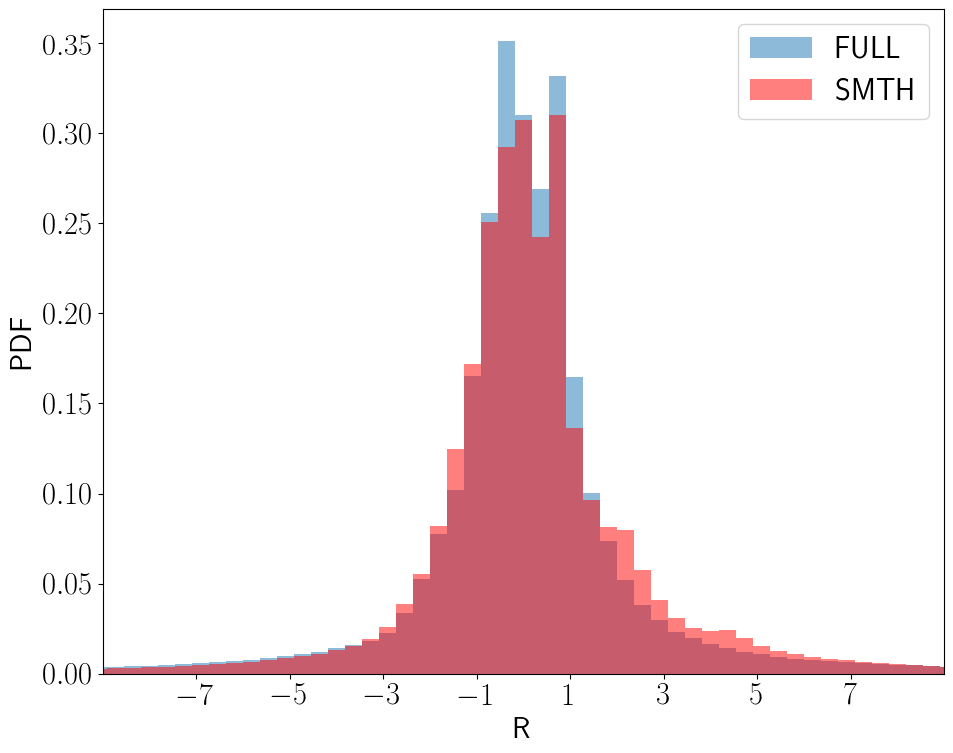

In [110]:
plt.figure(figsize=(10,8))

plt.hist(np.ravel(R_f),bins=55,range=[-10,10],alpha=0.5,density='True',label='FULL')
plt.hist(np.ravel(R_t),bins=55,range=[-10,10],alpha=0.5,color='red',density='True',label='SMTH')
plt.xlim(-9,9)
plt.legend()
plt.ylabel('PDF')
plt.xticks([-7,-5,-3,-1,1,3,5,7])
# plt.xlabel(r'$\frac{g \alpha_{\theta} \Delta T }{ g \beta_{S} \Delta S}$')

plt.xlabel(r'R')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/density_ratio_histogram.png')


# Separated components of buoyancy and $B_o$
## Buoyancy

In [23]:
b_temp_full=xrft.isotropic_power_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)
b_temp_smth=xrft.isotropic_power_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

In [24]:
b_salt_full=xrft.isotropic_power_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)
b_salt_smth=xrft.isotropic_power_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

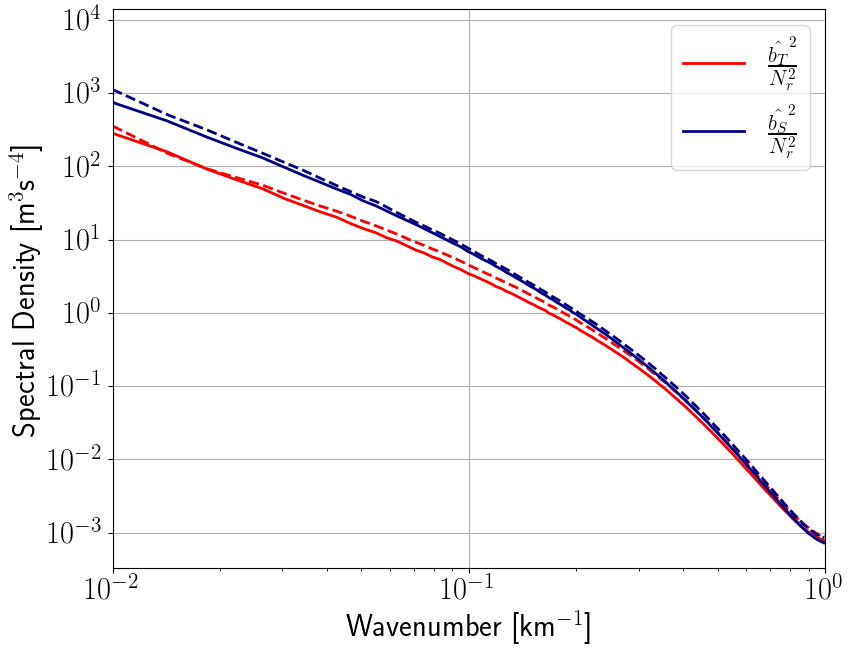

In [28]:
plt.figure(figsize=(9,7))


plt.plot(b_temp_full.freq_r/dxx,(1/(2*N2r))*(b_temp_full).mean(axis=0)/dxx*1e3,linewidth=2,color='red',label=r'$\frac{\hat{b_T}^2}{N^2_r}$')
plt.plot(b_temp_smth.freq_r/dxx,(1/(2*N2r))*(b_temp_smth).mean(axis=0)/dxx*1e3,'--',linewidth=2,color='red')

plt.plot(b_salt_full.freq_r/dxx,(1/(2*N2r))*(b_salt_full).mean(axis=0)/dxx*1e3,linewidth=2,color='navy',label=r'$\frac{\hat{b_S}^2}{N^2_r}$')
plt.plot(b_salt_smth.freq_r/dxx,(1/(2*N2r))*(b_salt_smth).mean(axis=0)/dxx*1e3,'--',linewidth=2,color='navy')


plt.legend()

plt.yscale('symlog',linthresh=1e-9)
# plt.yscale('log')
plt.xscale('log')



# plt.title(r'$\frac{ \,b_T \,Bo_S}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{3}$s$^{-4}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/EPE_(b-.-N2)__components.png')

In [47]:
Bo_temp_full=xrft.isotropic_power_spectrum(Bot_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)
Bo_temp_smth=xrft.isotropic_power_spectrum(Bot_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

In [48]:
Bo_salt_full=xrft.isotropic_power_spectrum(Bos_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)
Bo_salt_smth=xrft.isotropic_power_spectrum(Bos_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

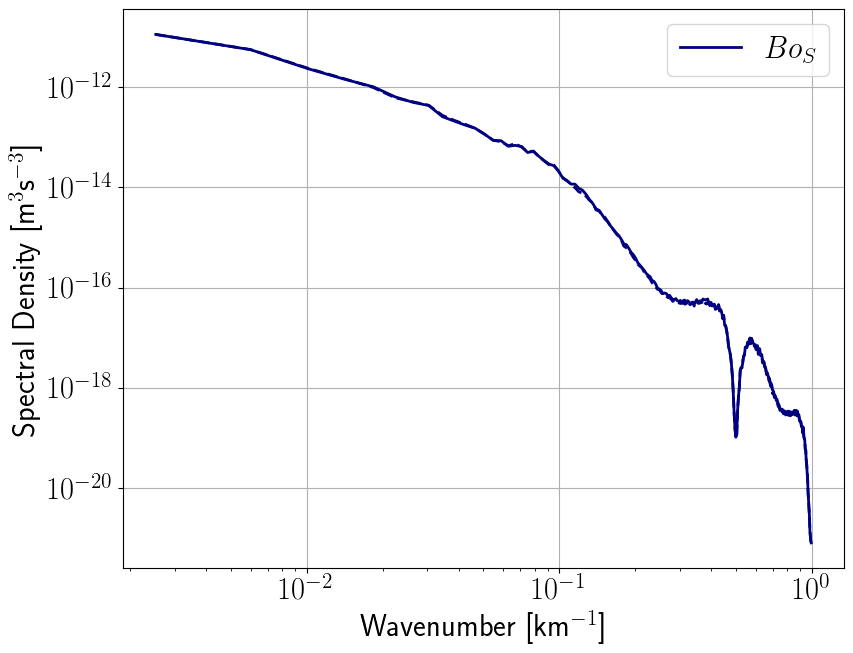

In [53]:
plt.figure(figsize=(9,7))


# plt.plot(Bo_temp_full.freq_r/dxx,Bo_temp_full.mean(axis=0)/dxx*1e3,linewidth=2,color='red',label=r'$Bo_T$')
# plt.plot(Bo_temp_smth.freq_r/dxx,Bo_temp_smth.mean(axis=0)/dxx*1e3,'--',linewidth=2,color='red')

plt.plot(Bo_salt_full.freq_r/dxx,Bo_salt_full.mean(axis=0)/dxx*1e3,linewidth=2,color='navy',label=r'$Bo_S$')
plt.plot(Bo_salt_smth.freq_r/dxx,Bo_salt_smth.mean(axis=0)/dxx*1e3,'--',linewidth=2,color='navy')



# plt.yscale('symlog',linthresh=1e-9)
plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Spectral Density [m$^{3}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.legend()

# plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/Bo_components_allwavenumbers.png')

